In [80]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import glob
import os
import pandas as pd
import xarray as xr
from rasterio.enums import Resampling
from scipy.signal import convolve2d

In [81]:
name = 'COPP'
BS = f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson'
# utm_epsg = 'EPSG:32611'
utm_epsg = 'EPSG:26913'
basin = gpd.read_file(BS).to_crs(utm_epsg)

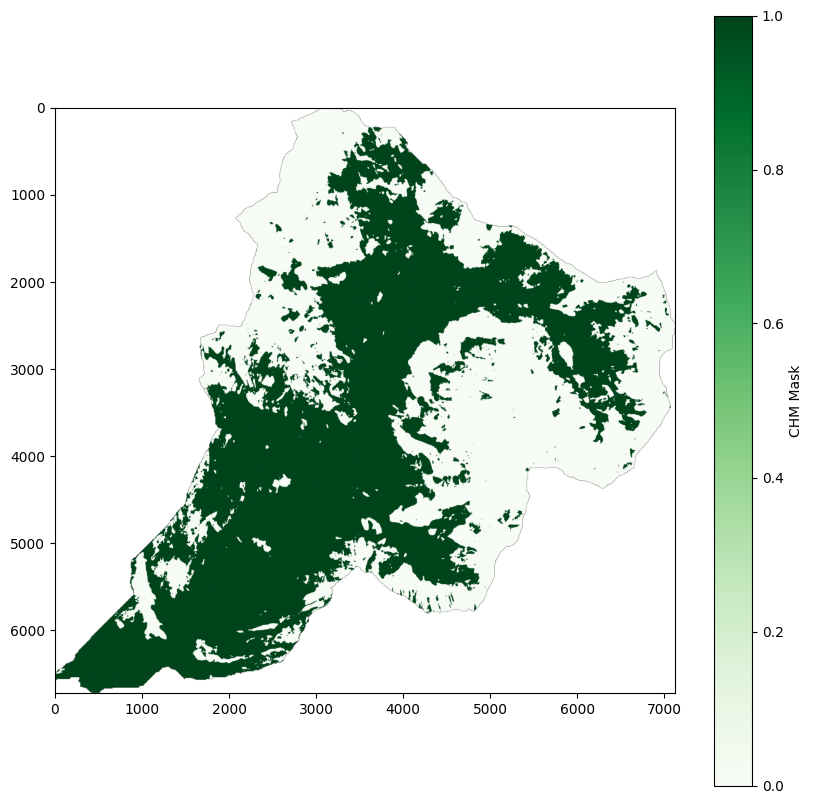

In [82]:

# chm_mask = rxr.open_rasterio('/home/etboud/projects/data/CHM/USCATB20140827_chm_3p0m.tif', all_touched=False,drop=True, masked=True).rio.clip(basin.geometry.values, all_touched = False,  drop=True)
# chm_mask.values = np.where(chm_mask < 2, 0, chm_mask) 
# chm_mask.values = np.where(chm_mask > 2, 1, chm_mask) 
chm_mask = rxr.open_rasterio(f'/home/etboud/projects/data/masks/4b_15img_ndvi_30_85_{name}_notclipped.tif',masked =False)
basin_mask = rxr.open_rasterio(f'/home/etboud/projects/data/masks/{name}_mask.tif', masked=True).rio.clip(basin.geometry.values, all_touched = False,  drop=True)
chm_mask.rio.set_nodata(np.nan, inplace=True)
chm_mask = chm_mask.rio.clip(basin.geometry.values, all_touched = False,  drop=True)
chm_mask.values = np.where(chm_mask.values > 0, 1.0, 0.0)  # Ensure float type for handling NaN
chm_mask.values = np.where(basin_mask == 1, chm_mask, np.nan)  # Apply basin mask
chm_mask = chm_mask.rio.reproject(utm_epsg, resolution=1.0, resampling=Resampling.mode)
opnclass = -chm_mask.values
canclass = chm_mask.values-1

ingrid_opn = chm_mask.values
ingrid_can = -(chm_mask.values-1)
ingrid_opn = ingrid_opn[0]
ingrid_can = ingrid_can[0]
#plot chm_mask
plt.figure(figsize=(10, 10))
plt.imshow(chm_mask[0], cmap='Greens', vmin=0, vmax=1)
plt.colorbar(label='CHM Mask')


In [83]:
def create_circular_kernel(radius):
    """Create a circular kernel of specified radius."""
    size = 2 * radius + 1
    kernel = np.zeros((size, size), dtype=np.float32)
    center = radius

    for x in range(size):
        for y in range(size):
            if np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius:
                kernel[x, y] = 1

    return kernel

kernel = create_circular_kernel(1)

In [84]:
step_nr = 350

In [85]:

from scipy.ndimage import convolve

# Ensure the kernel is defined
kernel = create_circular_kernel(1)

for ssx in range(1, step_nr + 1):
    chmsm_opn = convolve(ingrid_opn, kernel, mode='constant', cval=0)
    chmsm_can = convolve(ingrid_can, kernel, mode='constant', cval=0)

    # detect edges
    # opn_update_mask = (opnclass == 0) & (chmsm_opn > 0)
    opn_update_mask =(opnclass == 0) & (ingrid_opn == 0) & (chmsm_opn > 0)
    opnclass[opn_update_mask] = ssx
    can_update_mask = (canclass == 0) & (chmsm_can > 0)
    canclass[can_update_mask] = ssx
    # Prepare for next iteration: rebinarize smoothed results
    ingrid_opn = (chmsm_opn > 0).astype(np.uint8)
    ingrid_can = (chmsm_can > 0).astype(np.uint8)
    

opnclass = np.where(opnclass < 0, 0,opnclass)
canclass = np.where(canclass < 0, 0,canclass)
dceall = -1*(canclass-opnclass)

dceall = np.where((canclass == 0) & (opnclass == 0), np.nan, dceall)

#resample to original resolution
chm_mask.values = dceall
dce_output = chm_mask.rio.reproject(utm_epsg, resolution=3.0, resampling=Resampling.bilinear)








In [92]:
dce_groups = xr.full_like(dce_output, fill_value=np.nan)

dce = dce_output  # shorthand

# Apply groups using chained conditions
dce_groups = xr.where((dce < -9), -1, dce_groups) # no data
dce_groups = xr.where(((dce >= -9) & (dce < -3)), 0, dce_groups) # forest cluster
dce_groups = xr.where(((dce >= -3) & (dce <= 3)), 1, dce_groups) # forest edge
dce_groups = xr.where(((dce > 3) & (dce <= 9)), 2, dce_groups) # small gaps
dce_groups = xr.where(((dce > 9) & (dce <= 15)), 3, dce_groups) # medium gaps
dce_groups = xr.where(((dce > 15) & (dce <= 27)), 4, dce_groups) # large gaps
dce_groups = xr.where(((dce > 27) & (dce <= 100)), 5, dce_groups) # outside forest
dce_groups = xr.where((dce >100), 6, dce_groups) # water

In [93]:
basin_mask = rxr.open_rasterio(f'/home/etboud/projects/data/masks/{name}_mask.tif')
# only dce_groups where basin mask
dce_groups = dce_groups.where(basin_mask.squeeze() == 1)

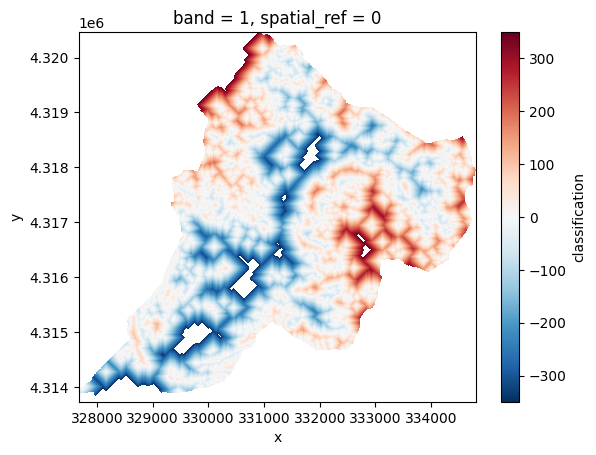

In [99]:
dce_output.plot()

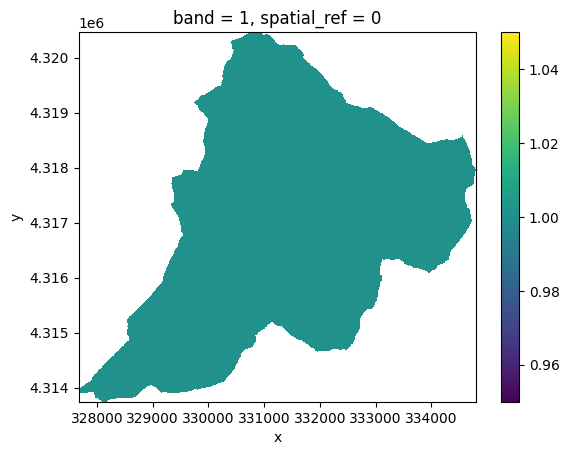

In [76]:
basin_mask.plot()

In [78]:
basin_mask.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32613"]]')

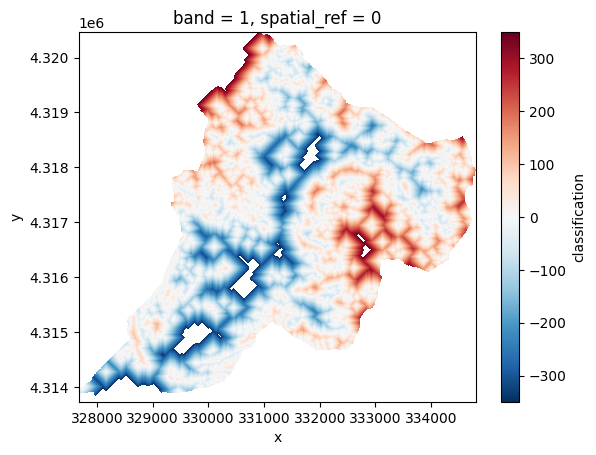

In [94]:
dce_output.plot()

/tmp/ipykernel_3777865/1725298657.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(dce_groups.squeeze(), cmap=cmap)
/tmp/ipykernel_3777865/1725298657.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(dce_groups.squeeze(), cmap=cmap)


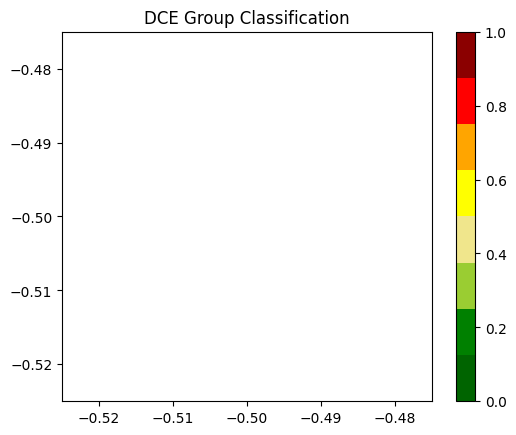

In [95]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap([
    "darkgreen",  # 
    "green",  # dark green - forest cluster
    "yellowgreen",  # medium green - forest edge
    "khaki",  # light green - small gaps
    "yellow",  # yellow - medium gaps
    "orange",  # orange - large gaps
    "red",   # red - open
    "darkred"
])

plt.imshow(dce_groups.squeeze(), cmap=cmap)
plt.colorbar()
plt.title("DCE Group Classification")
plt.show()

In [144]:
# Print basic stats for DCE
print("DCE min:", np.nanmin(dce.values))
print("DCE max:", np.nanmax(dce.values))

# Check range of DCE values in open areas
open_mask = (basin_mask.values == 1)  # assuming chm_mask == 1 means open
open_dce_values = dce.values[open_mask]

print("Open DCE stats:")
print("Min:", np.nanmin(open_dce_values))
print("Max:", np.nanmax(open_dce_values))
print("Mean:", np.nanmean(open_dce_values))

DCE min: -498.0
DCE max: 98.0
Open DCE stats:
Min: -69.0
Max: 98.0
Mean: 8.14038853542529


In [90]:
# /home/etboud/projects/data/temp/BUDD/M1/20200421_163154_SCA.tif
# /home/etboud/projects/data/temp/COPP/base/20220406_175117_SCA.tif
# /home/etboud/projects/data/temp/DLNY/base/20220405_174728_SCA.tif
temp = rxr.open_rasterio ('/home/etboud/projects/data/temp/COPP/base/20220406_175117_SCA.tif').rio.clip(basin.geometry.values, all_touched = False,  drop=True)
temp.values = dce_groups.values


ValueError: replacement data must match the Variable's shape. replacement data has shape (1, 0, 0); Variable has shape (1, 2240, 2373)

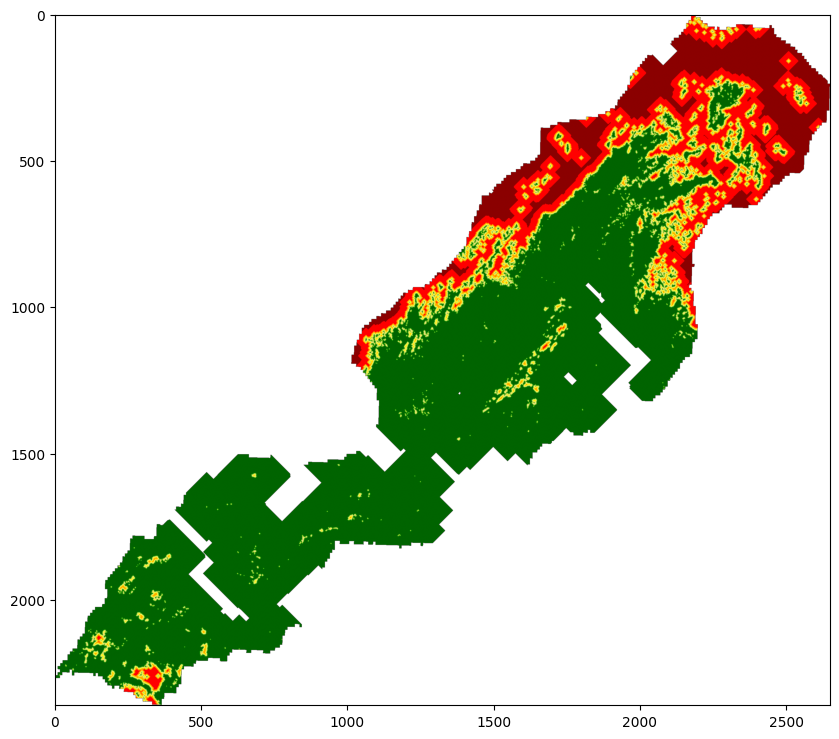

In [62]:
# plot temp
plt.figure(figsize=(10, 10))
plt.imshow(temp.squeeze(), cmap=cmap)

In [63]:
temp.rio.to_raster('/home/etboud/projects/data/masks/dce_classes_DLNY.tif', driver='GTiff', dtype='float32', nodata=np.nan)